# Step 0: Install Environment


In [1]:
# check GPU
!nvidia-smi

Fri Aug 18 07:22:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:

import os
!git clone https://github.com/cuiaiyu/dressing-in-order
repo_name='dressing-in-order'
os.chdir(f'./{repo_name}')

Cloning into 'dressing-in-order'...
remote: Enumerating objects: 209, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 209 (delta 89), reused 180 (delta 74), pack-reused 0
Receiving objects: 100% (209/209), 5.13 MiB | 20.94 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [3]:
!pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 2.7 MB/s eta 0:00:00


# Step 1: Download Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip /content/drive/MyDrive/project/images.zip -d /content/dressing-in-order/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/dressing-in-order/data/images/WOMEN-Tees_Tanks-id_00004558-03_7_additional.jpg  
  inflating: /content/dressing-in-order/data/images/WOMEN-Tees_Tanks-id_00004559-03_1_front.jpg  
  inflating: /content/dressing-in-order/data/images/WOMEN-Tees_Tanks-id_00004559-03_4_full.jpg  
  inflating: /content/dressing-in-order/data/images/WOMEN-Tees_Tanks-id_00004559-03_7_additional.jpg  
  inflating: /content/dressing-in-order/data/images/WOMEN-Tees_Tanks-id_00004559-04_1_front.jpg  
  inflating: /content/dressing-in-order/data/images/WOMEN-Tees_Tanks-id_00004559-04_2_side.jpg  
  inflating: /content/dressing-in-order/data/images/WOMEN-Tees_Tanks-id_00004559-04_4_full.jpg  
  inflating: /content/dressing-in-order/data/images/WOMEN-Tees_Tanks-id_00004559-04_7_additional.jpg  
  inflating: /content/dressing-in-order/data/images/WOMEN-Tees_Tanks-id_00004560-06_1_front.jpg  
  inflating: /content/dressing-in-order/data/images/WOM

In [6]:
# download data
import os
from tqdm.notebook import tqdm

if not os.path.exists("data/"):
  os.system("mkdir data")

def download_from_gdrive(dst_root, fn, gdrive_path, iszip=True):
  if not os.path.exists(dst_root):
    os.system("mkdir {}".format(dst_root))
  if not os.path.exists("{}/{}".format(dst_root, fn)):
    os.system("gdown {}".format(gdrive_path))
    if iszip:
      os.system("unzip {}.zip".format(fn))
      os.system("rm {}.zip".format(fn))
    os.system("mv {} {}/".format(fn, dst_root))
  print("download {}.".format(fn))

# download data
download_from_gdrive("data", "testM_lip", "1toeQwAe57LNPTy9EWGG0u1XfTI7qv6b1")
download_from_gdrive("data", "images", "1U2PljA7NE57jcSSzPs21ZurdIPXdYZtN")
download_from_gdrive("data","fasion-pairs-test.csv","12fZKGf0kIu5OX3mjC-C3tptxrD8sxm7x",iszip=False)
download_from_gdrive("data","fasion-annotation-test.csv","1MxkVFFtNsWFshQp_TA7qwIGEUEUIpYdS",iszip=False)
download_from_gdrive("data","standard_test_anns.txt","19nJSHrQuoJZ-6cSl3WEYlhQv6ZsAYG-X",iszip=False)

# filter images
if not os.path.exists("data/test"):
  os.mkdir("data/test")
target_fns = [fn[:-4] for fn in os.listdir("data/testM_lip")]
for fn in tqdm(os.listdir("data/images")):
  elements = fn.split("-")
  elements[2] = elements[2].replace("_","")
  last_elements = elements[-1].split("_")
  elements[-1] = last_elements[0] + "_" + last_elements[1] + last_elements[2]
  new_fn = "fashion"+"".join(elements)

  if new_fn[:-4] in target_fns:
    os.system("mv {} {}".format("data/images/"+fn, "data/test/"+new_fn))



download testM_lip.
download images.
download fasion-pairs-test.csv.
download fasion-annotation-test.csv.
download standard_test_anns.txt.


  0%|          | 0/44096 [00:00<?, ?it/s]

# Step 2: Load Pre-trained Model

In [7]:
import torch
from models.dior_model import DIORModel
import os, json
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
!pip install scikit-image==0.18.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 41.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-image: filename=scikit_image-0.18.0-cp310-cp310-linux_x86_64.whl size=35948058 sha256=4b7f452c2a970b20d10d4e77a4a1655366514e1828167b0fda520ca8b8a9cab1
  Stored in directory: /root/.cache/pip/wheels/81/21/b4/bea1d12869cffd23f9d1e353b69240238d05ad4e62f57ff6ce
Successfully built scikit-image
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3


In [8]:
dataroot = 'data'
exp_name = 'DIORv1_64'
epoch = 'latest'
netG = 'diorv1'
ngf = 64

class Opt:
    def __init__(self):
        pass
if True:
    opt = Opt()
    opt.dataroot = dataroot
    opt.isTrain = False
    opt.phase = 'test'
    opt.n_human_parts = 8; opt.n_kpts = 18; opt.style_nc = 64
    opt.n_style_blocks = 4; opt.netG = netG; opt.netE = 'adgan'
    opt.ngf = ngf
    opt.norm_type = 'instance'; opt.relu_type = 'leakyrelu'
    opt.init_type = 'orthogonal'; opt.init_gain = 0.02; opt.gpu_ids = [0]
    opt.frozen_flownet = True; opt.random_rate = 1; opt.perturb = False; opt.warmup=False
    opt.name = exp_name
    opt.vgg_path = ''; opt.flownet_path = ''
    opt.checkpoints_dir = 'checkpoints'
    opt.frozen_enc = True
    opt.load_iter = 0
    opt.epoch = epoch
    opt.verbose = False

# create model
#os.mkdir("checkpoints")
download_from_gdrive("checkpoints", "DIORv1_64", "1MyHq-P0c8zz7ey7p_HTTZKeMie5ZuNlb")

model = DIORModel(opt)
model.setup(opt)


download DIORv1_64.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 60.8MB/s]


load vgg ckpt from torchvision dict.
[init] init pre-trained model vgg.
initialize network with orthogonal
initialize network with orthogonal
initialize network with kaiming
initialize network with orthogonal
[init] frozen net netVGG.
[init] frozen net netFlow.
[init] frozen net netE_attr.
[init] frozen net netE_attr.
loading the model from checkpoints/DIORv1_64/latest_net_E_attr.pth
loading the model from checkpoints/DIORv1_64/latest_net_G.pth
not exsits checkpoints/DIORv1_64/latest_net_VGG.pth
loading the model from checkpoints/DIORv1_64/latest_net_Flow.pth
---------- Networks initialized -------------
[Network E_attr] Total number of parameters : 1.191 M
[Network G] Total number of parameters : 16.501 M
[Network VGG] Total number of parameters : 0.113 M
[Network Flow] Total number of parameters : 6.608 M
-----------------------------------------------
[tensorboard] init tensorboard @ checkpoints/DIORv1_64/test


-1

In [9]:
# load data
from datasets.deepfashion_datasets import DFVisualDataset
Dataset = DFVisualDataset
ds = Dataset(dataroot=dataroot, dim=(256,176), n_human_part=8)

# preload a set of pre-selected models for quick visualizations
inputs = dict()
for attr in ds.attr_keys:
    inputs[attr] = ds.get_attr_visual_input(attr)

# define tool functions for I/O
def load_img(pid, ds):
    if len(pid[0]) < 10: # load pre-selected models
        person = inputs[pid[0]]
        person = (i.cuda() for i in person)
        pimg, parse, to_pose = person
        pimg, parse, to_pose = pimg[pid[1]], parse[pid[1]], to_pose[pid[1]]
    else: # load model from scratch
        person = ds.get_inputs_by_key(pid[0])
        person = (i.cuda() for i in person)
        pimg, parse, to_pose = person
    return pimg.squeeze(), parse.squeeze(), to_pose.squeeze()

def plot_img(pimg=[], gimgs=[], oimgs=[], gen_img=[], pose=None):
    if pose != None:
        import utils.pose_utils as pose_utils
        print(pose.size())
        kpt = pose_utils.draw_pose_from_map(pose.cpu().numpy().transpose(1,2,0),radius=6)
        kpt = kpt[0]
    if not isinstance(pimg, list):
        pimg = [pimg]
    if not isinstance(gen_img, list):
        gen_img = [gen_img]
    out = pimg + gimgs + oimgs + gen_img
    if out:
        out = torch.cat(out, 2).float().cpu().detach().numpy()
        out = (out + 1) / 2 # denormalize
        out = np.transpose(out, [1,2,0])

        if pose != None:
            out = np.concatenate((kpt, out),1)
    else:
        out = kpt
    fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')
    plt.axis('off')
    plt.imshow(out)

def dress_in_order(model, pid, pose_id=None, gids=[], ogids=[], order=[5,1,3,2], perturb=False):
    PID = [0,4,6,7]
    GID = [2,5,1,3]
    # encode person
    pimg, parse, from_pose = load_img(pid, ds)
    if perturb:
        pimg = perturb_images(pimg[None])[0]
    if not pose_id:
        to_pose = from_pose
    else:
        to_img, _, to_pose = load_img(pose_id, ds)
    psegs = model.encode_attr(pimg[None], parse[None], from_pose[None], to_pose[None], PID)

    # encode base garments
    gsegs = model.encode_attr(pimg[None], parse[None], from_pose[None], to_pose[None])


    # swap base garment if any
    gimgs = []
    for gid in gids:
        _,_,k = gid
        gimg, gparse, pose =  load_img(gid, ds)
        seg = model.encode_single_attr(gimg[None], gparse[None], pose[None], to_pose[None], i=gid[2])
        gsegs[gid[2]] = seg
        gimgs += [gimg * (gparse == gid[2])]

    # encode garment (overlay)
    garments = []
    over_gsegs = []
    oimgs = []
    for gid in ogids:
        oimg, oparse, pose = load_img(gid, ds)
        oimgs += [oimg * (oparse == gid[2])]
        seg = model.encode_single_attr(oimg[None], oparse[None], pose[None], to_pose[None], i=gid[2])
        over_gsegs += [seg]

    gsegs = [gsegs[i] for i in order] + over_gsegs
    gen_img = model.netG(to_pose[None], psegs, gsegs)

    return pimg, gimgs, oimgs, gen_img[0], to_pose



# Applications

NOTE: INDEX OF GARMENT is used as following:

- 'top':5, # dress is also considered as top.
- 'bottom':1,
- 'hair':2,
- 'jacket':3


## Pose Transfer

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/content/dressing-in-order/utils/pose_utils.py:91: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
  yy, xx = circle(joint[0], joint[1], radius=radius, shape=img_size)


torch.Size([18, 256, 176])


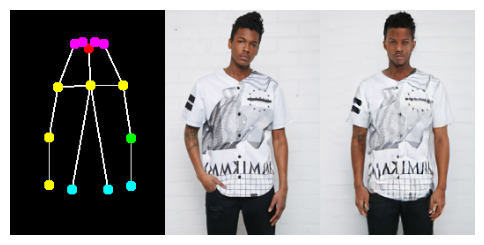

In [10]:
import numpy as np
%matplotlib inline
# person id
pid = ("print", 0, None) # load the 0-th person from "print" group, NONE (no) garment is interested
# pose id (take this person's pose)
pose_id = ("print", 2, None) # load the 2-nd person from "print" group, NONE (no) garment is interested
# generate
pimg, gimgs, oimgs, gen_img, pose = dress_in_order(model, pid, pose_id=pose_id)
plot_img(pimg, gimgs, oimgs, gen_img, pose)
plt.show()

## Virtual Try-On (Tucking in/out)


torch.Size([18, 256, 176])


torch.Size([18, 256, 176])


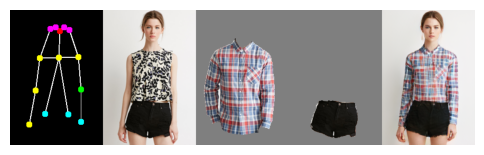

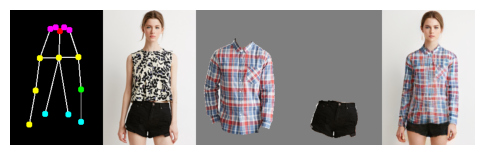

In [12]:
pid = ("pattern", 3, None) # load the 3-rd person from "pattern" group, NONE (no) garment is interested
gids = [
   ("plaid",0,5), # load the 0-th person from "plaid" group, garment #5 (top) is interested
   ("pattern",3,1),  # load the 3-rd person from "pattern" group, garment #1 (bottom) is interested
       ]

# tuck in (dressing order: hair, top, bottom)
pimg, gimgs, oimgs, gen_img, pose = dress_in_order(model, pid, gids=gids, order=[2,5,1])
plot_img(pimg, gimgs, gen_img=gen_img, pose=pose)

# not tuckin (dressing order: hair, bottom, top)
pimg, gimgs, oimgs, gen_img, pose = dress_in_order(model, pid, gids=gids, order=[2,1,5])
plot_img(pimg, gimgs, gen_img=gen_img, pose=pose)
plt.show()



## Virtual Try-On (Layering)


torch.Size([18, 256, 176])


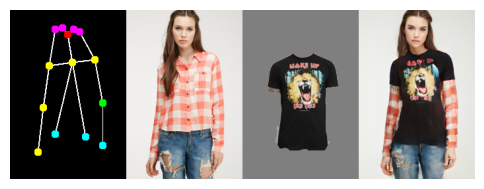

In [13]:
pid = ('plaid',3, 5)
ogids = [('print', 2, 5)]
# tuck in
pimg, gimgs, oimgs, gen_img, pose = dress_in_order(model, pid, ogids=ogids)
plot_img(pimg, gimgs, oimgs, gen_img, pose)
#plt.imshow(pimg)
plt.show()

## Virual Try-On (Layering - Multiple)


torch.Size([18, 256, 176])


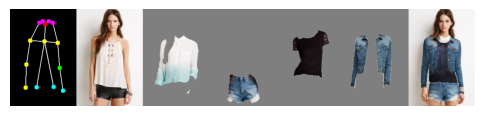

In [14]:
# person id
pid = ("fashionWOMENBlouses_Shirtsid0000637003_1front.jpg", None , None) # load person from the file

# garments to try on (ordered)
gids = [
    ("gfla",2,5),
    ("strip",3,1),
       ]

# garments to lay over (ordered)
ogids = [
 ("fashionWOMENTees_Tanksid0000159006_1front.jpg", None ,5),
 ('fashionWOMENJackets_Coatsid0000645302_1front.jpg', None ,3),
]

# dressing in order
pimg, gimgs, oimgs, gen_img, pose = dress_in_order(model, pid=pid, gids=gids, ogids=ogids)
plot_img(pimg, gimgs, oimgs, gen_img, pose)
plt.show()